### Run for many points

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
f_dig_lp:  0.0374933333333


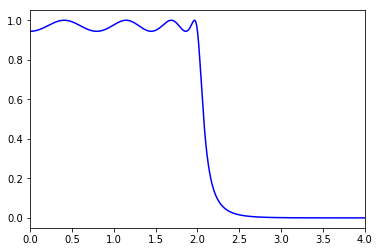

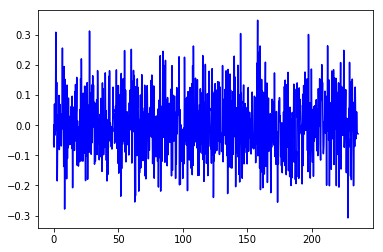

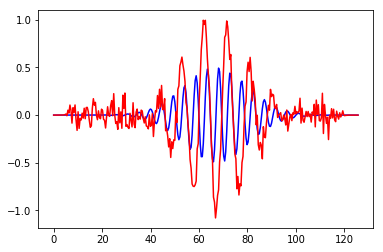

del_eps: 0.06040000000000001
r0: [ 0.] r1: [ 125.66370614]
r_T_1d: [ 116.23892818] r_R_1d: [ 9.42477796]
simulation time: 0:11
max(e_max): 5.86567786858
max(deps_max): 0.0300826321799
max(T): 4.88098844003
max(R): 0.00238579315848


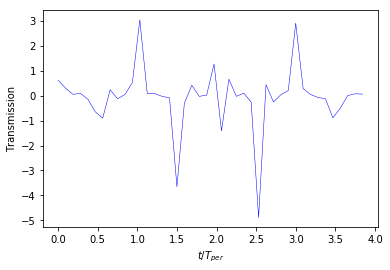

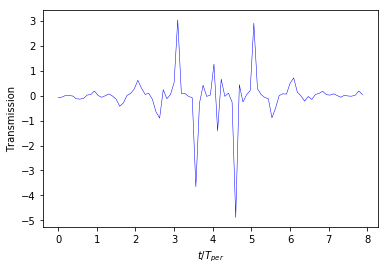

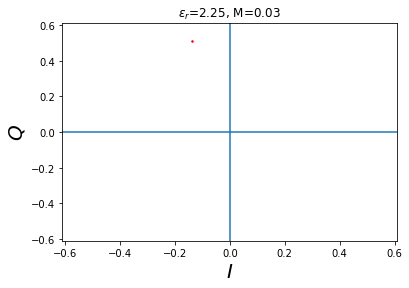

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:491: RuntimeWarning: invalid value encountered in arccos


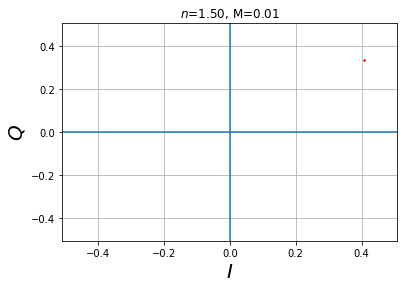

Populating the interactive namespace from numpy and matplotlib


In [1]:
%pylab tk

from Electromagnetics.FDTD import *
import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'spacetime-noise')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

figsize(6,4)
e_max = 0.0

def Run_IQ(n_refr_ind_0, n_refr_ind_1, amp_noise=1.0, amp_med=0.5, phi_med_deg=90.0, phi_detect_deg=0.0, \
               save_every = 1, show_figs = False, show_animation=False):
    global e_max
    n_dim = 1
    r0, r1, dr = [None]*3
    S = 0.95
    n_t = None
    save_every = save_every

    r_c = None
    r0_eps, r1_eps = None, None
    r0_deps, r1_deps = None, None
    a_eps, b_eps = None, None
    omega = 1.0 #2.0*np.pi
    omega_ref = omega
    s_pml = None
    d_pml = None
    set_pml = True
    is_t_var = True

    n0 = n_refr_ind_0
    n1 = n_refr_ind_1
    del_eps = n1**2 - n0**2

    L_0 = 2.0*np.pi/(omega_ref*n0)
    L_1 = 2.0*np.pi/(omega_ref*n1)



    if n_dim==1:
        r0 = np.array([0.0])
        r1 = np.array([30.0*L_0])
        dr = np.array([L_0/100])
        S /= np.sqrt(1)
        n_t = 4000

        d_pml = np.array([2.0*L_0])
        s_pml = np.array([1.0+2.5j/L_0])

        r_c = (r0+r1)/2.0
        a_eps, b_eps = n0**2, n1**2

        W_slab = r1-r0-3*d_pml
        r0_deps = r_c - W_slab/2
        r1_deps = r_c + W_slab/2

        r0_eps = r0.copy()
        r1_eps = r1.copy()

    else:
        assert False

    dt = S*dr[0]*(min(n0,n1)-abs(n0-n1))
    d_v = np.prod(dr)

    dt_dr = dt/dr[0]

    fdtd = FDTDSimulator()

    fdtd.SetSimulationBox(r0, r1, dr, dt)
    fdtd.save_every = save_every 

    d_x_ = np.zeros(n_dim)
    d_x_[0] = (r1[0]-r0[0])
    d_x_pml = np.zeros(n_dim)
    d_x_pml[0] = d_pml[0]

    ##----- filtered noise

    from scipy import signal

    def setLPNoiseSamples(f_anal_lp=2.0):
        t_samples = np.linspace(0.0, n_t*dt, n_t)
        f_noise = 0.2*np.random.normal(0.0, 1.0, size=n_t)

        f_dig_lp = f_anal_lp*dt/np.pi 
        print('f_dig_lp: ', f_dig_lp)
        b, a = signal.cheby1(8, rp=0.5, Wn=f_dig_lp*2.0*np.pi, btype='low', analog=False, output='ba')
        w, h = signal.freqz(b, a, worN=n_t)

        if show_figs:
            plt.figure()
            plt.plot(w/(2*np.pi)/dt, np.abs(h), 'b')
            xlim(0, 2.0*f_anal_lp)
            plt.show()

        noise_LP = signal.filtfilt(b, a, f_noise, padlen=0)
        if show_figs:
            plt.figure()
            plt.plot(t_samples, noise_LP, 'b')
            plt.show()
        return noise_LP

    noise_LP = None
    read_saved_noise = False

    if not read_saved_noise:
        noise_LP = setLPNoiseSamples()
        np.savez(os.path.join(dir_name, 'noise_LP'), noise_LP=noise_LP)
    else:
        data_noise_LP = np.load(os.path.join(dir_name, 'noise_LP.npz'))
        noise_LP = data_noise_LP['noise_LP']

    def f_noise_LP(t):
        i_t = int(t//dt)
        if i_t<n_t-1:
            alpha = (t-i_t*dt)/dt
            return (1-alpha)*noise_LP[i_t] + alpha*noise_LP[i_t+1]
        else:
            return 0.0

    ##------

    smooth_rect = lambda t, t0, t1, T_rise: 0.5*(np.tanh((t - t1)/T_rise) - np.tanh((t - t0)/T_rise))


    ##----- sources

    T_per = 2.0*np.pi/omega
    T_0 = 2.0*T_per
    t0 = 3.0*T_0
    f_t = lambda t: -1.0*np.exp(-(t-t0)**2/T_0**2)*np.cos(omega*(t-t0)) + amp_noise*f_noise_LP(t)*smooth_rect(t, 0.5*T_per, 6*T_0+0.5*T_per, 0.1*T_per)
    f_t_dt = lambda t: f_t(t-dr[0]/2*n0)

    ## J
    r_j = (r0_deps + d_pml)/2

    r_j -= r_j - int(r_j/dr[0])*dr[0]
    je_mag = 1.0/dr[0]*n0
    src_dir = 'z'
    je_type = FVTypes.JePoint
    je_args = {'r0':r_j, 'mag':je_mag, 'f_t':f_t, 'src_dir':src_dir}
    fdtd.AddSources({'type':je_type, 'name':'Je', 'args':je_args})

    ## M
    r_m = r_j - dr[0]/2      
    jm_mag = -1.0/dr[0]

    src_dir = 'y'
    jm_type = FVTypes.JmPoint
    jm_args = {'r0':r_m, 'mag':jm_mag, 'f_t':f_t_dt, 'src_dir':src_dir}
    fdtd.AddSources({'type':jm_type, 'name':'Jm', 'args':jm_args})


    eps_args = {'r0':r0_eps, 'r1':r1_eps, 'mag_in':a_eps, 'mag_out':a_eps}
    fdtd.AddMaterial({'type':FVTypes.EpsIsoBox, 'name':'eps', 'args':eps_args})

    ##---- st pulse medium

    Tm_0 = T_0
    omega_m = 2*omega
    phi_m = phi_med_deg/180.0*np.pi
    f_t_medium = lambda t: amp_med*np.exp(-(t-t0)**2/Tm_0**2)*np.cos(omega_m*(t-t0)+phi_m)

    if show_figs:
        plt.figure()
        _x = np.linspace(r0[0], r1[0], 300)
        plt.plot(_x, [f_t_medium(2*t0-(_x[i]-r_j[0])/n0) for i in range(len(_x))], 'b')
        plt.plot(_x, [f_t(2*t0-(_x[i]-r_j[0])/n0) for i in range(len(_x))], 'r')
        plt.show()

    deps = None
    f_deps = None
    deps_out = []
    if is_t_var:
        print('del_eps:', del_eps)
        a_deps = None
        if n_dim==1:
            a_deps = lambda r, t: del_eps*f_t_medium(t - (r-r_j[0])*n0)
        deps_args = {'r0':r0_deps, 'r1':r1_deps, 'mag_in':a_deps, 'mag_out':0.0}
        fdtd.AddMaterial({'type':FVTypes.EpsIsoSTvarBox, 'name':'deps', 'args':deps_args})

    if set_pml:
        pml_args = {'d_pml':d_pml, 's_pml':s_pml}
        fdtd.AddPML({'type':FVTypes.UPML, 'name':'pml', 'args':pml_args})

    set_Efields_entire_out = True
    set_eps_out = True
    set_j_out = False
    set_T_1d = True
    set_R_1d = True


    r_R_1d = 0.25*r0_deps + 0.75*(r0+d_pml)
    r_T_1d = 0.25*r1_deps + 0.75*(r1-d_pml)

    print('r0:', r0, 'r1:', r1)
    print('r_T_1d:', r_T_1d, 'r_R_1d:', r_R_1d)

    if set_Efields_entire_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'E', 'A_dir':'z', 'O_dir':None, 'name':'E'}})
    if set_j_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'Je', 'A_dir':'z', 'O_dir':None, 'name':'J'}})
    if n_dim==1 and set_T_1d:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_T_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'T'}})
    if n_dim==1 and set_R_1d:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_R_1d, 'args':{'A':'E', 'A_dir':'z', 'O_dir':'x', 'name':'R'}})

    if is_t_var and set_eps_out:
        fdtd.AddViewPlane({'type':FVTypes.VPSide, 'r':r_j, 'args':{'A':'deps', 'A_dir':'x', 'O_dir':None, 'name':'Eps'}})


    fdtd.StepFields(n_t)
    n_saved = fdtd.n_saved


    r_E, E_out_list = None, None
    x_E, y_E, z_E = [None]*3
    e_max = None
    if set_Efields_entire_out:
        r_E, E_out_list = fdtd.GetOutputs('E')
        if n_dim==3:
            x_E, y_E, z_E = r_E
        elif n_dim==2:
            x_E, y_E = r_E
        elif n_dim==1:
            x_E = r_E[0]
        e_max = [np.max(np.abs(e)) for e in E_out_list]
        print('max(e_max):', max(e_max))
        e_max = max(e_max)

    x_J, y_J, z_J = [None]*3
    j_max = None
    J_out_list = None
    if set_j_out:
        r_J, J_out_list = fdtd.GetOutputs('J')
        if n_dim==3:
            x_J, y_J, z_J = r_J
        elif n_dim==2:
            x_J, y_J = r_J
        elif n_dim==1:
            x_J = r_J[0]
        j_max = [np.max(np.abs(j)) for j in J_out_list]
        print('max(j_max):', max(j_max))
        j_max = max(j_max)



    x_deps, y_deps, z_deps = [None]*3
    deps_out_list = None
    deps_max = None
    if is_t_var and set_eps_out:
        r_deps, deps_out_list = fdtd.GetOutputs('Eps')
        if n_dim==3:
            x_deps, y_deps, z_deps = r_deps
        elif n_dim==2:
            x_deps, y_deps = r_deps
        elif n_dim==1:
            x_deps = r_deps[0]
        deps_max = [np.max(np.abs(de)) for de in deps_out_list]
        print('max(deps_max):', max(deps_max))
        deps_max = max(deps_max)


    x_T = None
    T_arr = None
    if n_dim==1 and set_T_1d:
        r_T, T_out_list = fdtd.GetOutputs('T')
        x_T = r_T[0]
        T_arr = np.array([t[0] for t in T_out_list])
        T_max = np.max(np.abs(T_arr))
        print('max(T):', T_max)

    x_R = None
    R_arr = None
    if n_dim==1 and set_R_1d:
        r_R, R_out_list = fdtd.GetOutputs('R')
        x_R = r_R[0]
        R_arr = np.array([t[0] for t in R_out_list])
        R_max = np.max(np.abs(R_arr))
        print('max(R):', R_max)

        
    ind_st = int(((r_T_1d - r_j[0])*n0 + t0 - T_0)//(dt*save_every))
    ind_end = ind_st + int(2*T_0//(dt*save_every))
    T_arr_trimmed = T_arr[ind_st:ind_end]

    if show_figs:
        plt.figure()
        plt.plot(np.arange(len(T_arr_trimmed))*dt*save_every/(2.0*np.pi/omega), T_arr_trimmed, 'b', lw=0.5)
        plt.xlabel(r'$t/T_{per}$')
        plt.ylabel(r'Transmission')
        plt.savefig(os.path.join(dir_name, 'T-eps={0:.2f}-M={1:.2f}'.format(n0**2, del_eps/n0**2) + file_ext), bbox_inches='tight', pad_inches=0.2)
        plt.show()
    
        if set_T_1d:
            #ind_st = int((r1_eps[0] - r0_eps[0])/dt*a_eps + (8*L_0_air + t0)/dt)

            #del_n = n1 - n0
            n_avg = n0
            ind_st = int(((r_T_1d - r_j[0])*n0 + T_0)//(dt*save_every))
            ind_end = ind_st + int(4*T_0//(dt*save_every))
            T_arr_trimmed = T_arr[ind_st:ind_end]

            plt.figure()
            plt.plot(np.arange(len(T_arr_trimmed))*dt*save_every/(2.0*np.pi/omega), T_arr_trimmed, 'b', lw=0.5)
            plt.xlabel(r'$t/T_{per}$')
            plt.ylabel(r'Transmission')
            plt.savefig(os.path.join(dir_name, 'T-eps={0:.2f}-M={1:.2f}'.format(n0**2, del_eps/n0**2) + file_ext), bbox_inches='tight', pad_inches=0.2)
            plt.show()

            omega_numerical = omega

            Q_sin = []
            Q_cos = []

            t_samples_T = np.linspace(ind_st*dt*save_every, ind_end*dt*save_every, len(T_arr_trimmed))
            q_cos = np.sum(T_arr_trimmed*np.cos(omega_numerical*t_samples_T))/(ind_end-ind_st)*2
            q_sin = np.sum(T_arr_trimmed*np.sin(omega_numerical*t_samples_T))/(ind_end-ind_st)*2
            #print(T_arr_trimmed[i*num_per*nt_per + i], end=' ')

            Q_cos.append(q_cos)
            Q_sin.append(q_sin)

            Q_cos = np.array(Q_cos)
            Q_sin = np.array(Q_sin)
            Q_mag = Q_cos**2 + Q_sin**2
            Q_angle = np.arccos(Q_cos/Q_mag)

            plt.figure()
            plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
            #plt.polar(Q_angle, Q_mag)
            IQ_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin))) + 0.1
            plt.xlim(-IQ_max, IQ_max)
            plt.ylim(-IQ_max, IQ_max)
            plt.axvline(x=0)
            plt.axhline(y=0)
            plt.xlabel(r'$I$', fontsize=20)
            plt.ylabel(r'$Q$', fontsize=20)
            plt.title(r'$\epsilon_r$={0:.2f}, M={1:.2f}'.format(n0**2, del_eps/n0**2))
            #plt.grid()

            circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
            plt.gca().add_artist(circle)

            plt.savefig(os.path.join(dir_name, 'IQ-eps={0:.2f}-M={1:.2f}'.format(n0**2, del_eps/n0**2) + file_ext), bbox_inches='tight', pad_inches=0.5)
            plt.show()

    
    ##---- animations
    if show_animation:

        ## animations
        assert set_Efields_entire_out

        import matplotlib.animation as animation
        import matplotlib

        # Set up formatting for the movie files
        #Writer = animation.writers['mencoder']    ## avconv ffmpeg mencoder
        #writer = Writer(fps=15, metadata=dict(artist='Me'))
        #writer = animation.FFMpegWriter()

        #plt.rcParams["figure.figsize"] = (8, 5)

        plt_field = 'E'
        save_anim = False
        file_format = 'mp4'   ## 'gif' / 'mp4'

        logscale=False
        log_0 = np.log(e_max)-10

        use_subplots = False

        font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 14}
        matplotlib.rc('font', **font)

        fig, axarr = None, None
        e_max = 1.0
        def animate_E(i):
            global e_max
            if not is_t_var:
                plt.clf()
                fig = plt.plot(x_E, E_out_list[i])
                axes = plt.gca()
                axes.set_ylim([-e_max, e_max])
                return fig
            else:
                if not use_subplots:
                    plt.clf()
                    fig = None
                    if plt_field=='E':
                        fig = plt.plot(x_E/L_0, E_out_list[i])
                        ax = plt.gca()
                        e_max = max(e_max, int(np.max(np.abs(E_out_list[i]))/2.0)*2.0 + 1.0)
                        ax.set_ylim([-e_max, e_max])
                        #ax.set_ylim([-2.0, 2.0])
                        #ax.axes.get_xaxis().set_ticks([])
                        #ax.axes.get_yaxis().set_ticks([])

                        plt.plot(x_deps/L_0, 2*deps_out_list[i], 'r', lw=0.5)

                    elif plt_field=='Eps':
                        fig = plt.plot(x_deps, deps_out_list[i], 'r', lw=0.5)
                        ax = plt.gca()
                        ax.set_ylim([-deps_max, deps_max])
                        ax.axes.get_xaxis().set_ticks([])
                    #fig.set_tight_layout(True)
                    plt.xlabel(r'$z/\lambda_0$')
                    plt.ylabel(r'$E(t)$')
                    plt.title('$n_0={}, M={:.3}, D/\lambda_0={:.3} $'.format(n0, abs(n1-n0)/n0, (r1_deps-r0_deps)[0]/L_0))
                    ax = plt.gca()
                    ax.set_adjustable('box-forced')
                    #plt.gcf().subplots_adjust(left=0.2, bottom=0.3)

                    plt.axvline(x=(r0+d_pml)[0]/L_0, linewidth=1.0, linestyle='-.',color='r')
                    plt.axvline(x=(r1-d_pml)[0]/L_0, linewidth=1.0, linestyle='-.',color='r')

                    #plt.tight_layout(pad=0.0)

                    plt.plot([r_R_1d[0]/L_0], [0], marker='o', color='r')
                    plt.plot([r_T_1d[0]/L_0], [0], marker='o', color='r')

                    return fig
                else:
                    plt.clf()
                    fig, axarr = plt.subplots(2, sharex=True)
                    axarr[0].plot(x_E, E_out_list[i])
                    axarr[0].set_ylim([-e_max, e_max])
                    axarr[1].plot(x_deps, deps_out_list[i], 'r')
                    axarr[1].set_ylim([-deps_max, deps_max])
                    return fig


        def animate_J(i):
            plt.clf()
            fig = plt.plot(x_J, J_out_list[i])
            axes = plt.gca()
            axes.set_ylim([-j_max, j_max])
            return fig

        anim = None
        if is_t_var and use_subplots:
            fig, axarr = plt.subplots(2, sharex=True)
        else:
            fig = plt.figure()

        if plt_field=='E' or plt_field=='Eps':
            anim = animation.FuncAnimation(fig, animate_E, frames=n_saved, interval=1)
        elif plt_field=='J':
            anim = animation.FuncAnimation(fig, animate_J, frames=n_saved, interval=1)
        else:
            raise ValuError()

        if save_anim:
            if file_format=='gif':
                anim.save(os.path.join(dir_name, 'E1d-anim.gif'), writer="imagemagick", fps=15, dpi=200)
            elif file_format=='mp4':
                anim.save(os.path.join(dir_name, 'E1d-anim.mp4'), writer="ffmpeg", fps=15, dpi=200)
        plt.show()


    
    
    ##------ get the quadratures
    
    omega_numerical = omega
    
    Q_sin = []
    Q_cos = []

    phi_detect = phi_detect_deg/180*np.pi
    #t_samples_T = np.linspace(ind_st*dt*save_every, ind_end*dt*save_every, len(T_arr_trimmed))
    t_samples_T = np.linspace(0, (ind_end-ind_st)*dt*save_every, len(T_arr_trimmed))
    q_cos = np.sum(T_arr_trimmed*np.cos(omega_numerical*t_samples_T + phi_detect))/(ind_end-ind_st)*2
    q_sin = np.sum(T_arr_trimmed*np.sin(omega_numerical*t_samples_T + phi_detect))/(ind_end-ind_st)*2
    #print(T_arr_trimmed[i*num_per*nt_per + i], end=' ')

    Q_cos.append(q_cos)
    Q_sin.append(q_sin)
    
    Q_cos = np.array(Q_cos)
    Q_sin = np.array(Q_sin)
    Q_mag = Q_cos**2 + Q_sin**2
    Q_angle = np.arccos(Q_cos/Q_mag)
        
    if show_figs:
        plt.figure()
        plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
        #plt.polar(Q_angle, Q_mag)
        lim_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin)))+0.1
        plt.xlim(-lim_max, lim_max)
        plt.ylim(-lim_max, lim_max)
        plt.axvline(x=0)
        plt.axhline(y=0)
        plt.xlabel(r'$I$', fontsize=20)
        plt.ylabel(r'$Q$', fontsize=20)
        plt.title(r'$n$={0:.2f}, M={1:.2f}'.format(n0, abs(n1-n0)/n0))
        plt.grid()
    
        circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
        plt.gca().add_artist(circle)

        plt.savefig(os.path.join(dir_name, 'IQ-n={0:.2f}-M={1:.6f}'.format(n0, abs(n1-n0)/n0) + file_ext), bbox_inches='tight', pad_inches=0.5)
        plt.show()

    return Q_cos[0], Q_sin[0]



%pylab inline
figsize(6, 4)
Run_IQ(n_refr_ind_0=1.5, n_refr_ind_1=1.52, amp_noise=1.0, amp_med=0.5, save_every=10, show_figs=True, show_animation=False)


def get_IQ_points(n_refr_ind_0, n_refr_ind_1, amp_noise, amp_med, phi_med_deg, phi_detect_deg, n=10, show_every=10):
    I, Q = [], []
    for i in range(n):
        I_i, Q_i = Run_IQ(n_refr_ind_0, n_refr_ind_1, amp_noise, amp_med, phi_med_deg, phi_detect_deg)
        I.append(I_i)
        Q.append(Q_i)
        
        print("{}/{} ".format(i, n))
        if i%show_every==0:
            plt.plot(I, Q, 'ro', markersize=1.5)
            #lim_max = max(np.max(np.abs(I)), np.max(np.abs(Q)))+0.1
            #plt.xlim(-lim_max, lim_max)
            #plt.ylim(-lim_max, lim_max)
            plt.axes().set_aspect('equal', 'datalim')
            #plt.axvline(x=0)
            #plt.axhline(y=0)
            plt.xlabel(r'$I$', fontsize=20)
            plt.ylabel(r'$Q$', fontsize=20)
            plt.title(r'$n$={0:.2f}, M={1:.6f}'.format(n_refr_ind_0, abs(n_refr_ind_1-n_refr_ind_0)/n_refr_ind_0))
            plt.grid()

            #circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
            #plt.gca().add_artist(circle)
            plt.show()

    return I, Q


##-----------------  
%pylab inline
figsize(3, 3)

run_iq_simulation = False
n_refr_ind_0 = 1.5
n_refr_ind_1 = 1.515
amp_noise = 1.0
amp_med = 1.0
phi_med_deg = 90
phi_detect_deg = 0
N_IQ = 1000
if run_iq_simulation:
    figsize(5, 5)
    Q_cos, Q_sin = get_IQ_points(n_refr_ind_0, n_refr_ind_1, amp_noise, amp_med, \
                                 phi_med_deg, phi_detect_deg, N_IQ, show_every=50)
    
    plt.figure()
    plt.plot(Q_cos, Q_sin, 'ro', markersize=1.5 )
    #plt.polar(Q_angle, Q_mag)
    lim_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin)))+0.1
    plt.xlim(-lim_max, lim_max)
    plt.ylim(-lim_max, lim_max)
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.xlabel(r'$I$', fontsize=20)
    plt.ylabel(r'$Q$', fontsize=20)
    plt.title(r'$n$={0:.2f}, M={1:.6f}'.format(n_refr_ind_0, abs(n_refr_ind_1-n_refr_ind_0)/n_refr_ind_0))
    plt.grid()

    circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
    plt.gca().add_artist(circle)

    plt.savefig(os.path.join(dir_name, 'IQ-n={0:.2f}-M={1:.6f}'.format(n_refr_ind_0, abs(n_refr_ind_1-n_refr_ind_0)/n_refr_ind_0) + file_ext), bbox_inches='tight', pad_inches=0.5)
    plt.show()
    
    np.savez(os.path.join(dir_name, 'IQ-samples-n0={0:.2f}-n1={1:.2f}'.format(n_refr_ind_0, n_refr_ind_1)), 
             Q_cos=Q_cos, Q_sin=Q_sin, n_refr_ind_0=n_refr_ind_0, n_refr_ind_1=n_refr_ind_1, 
             amp_noise=amp_noise, amp_med=amp_med, phi_med_deg=phi_med_deg, phi_detect_deg=phi_detect_deg, N_IQ=N_IQ)

             
             

### Read saved data

Populating the interactive namespace from numpy and matplotlib
n_refr_ind_0:  1.5
n_refr_ind_1:  1.515
dn_n0:  0.009999999999999934
N_IQ:  1000


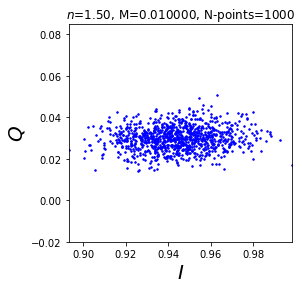

range Q:  0.104755208654
range I:  0.0362862654908


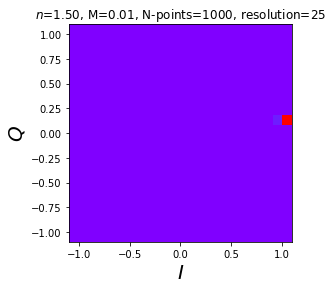

In [3]:
%pylab inline 

import numpy as np
import time
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
dir_name = os.path.join(cwd, 'other', 'spacetime-noise')
file_ext = '.png'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)


IQ_samples = np.load(os.path.join(dir_name, 'IQ-samples.npz'))
Q_cos = IQ_samples['Q_cos']
Q_sin = IQ_samples['Q_sin']
n_refr_ind_0 = float(IQ_samples['n_refr_ind_0'])
n_refr_ind_1 = float(IQ_samples['n_refr_ind_1'])
N_IQ = int(IQ_samples['N_IQ'])

dn_n0 = (n_refr_ind_1-n_refr_ind_0)/n_refr_ind_0

#n_refr_ind = 1.5
#M_eps_mod_ind = 0.25
#N_IQ = 2000

print('n_refr_ind_0: ', n_refr_ind_0)
print('n_refr_ind_1: ', n_refr_ind_1)
print('dn_n0: ', dn_n0)
print('N_IQ: ', N_IQ)

figsize(4, 4)

zoom_in = True
plt.figure()
plt.plot(Q_cos, Q_sin, 'bo', markersize=1.5 )
#plt.polar(Q_angle, Q_mag)
plt.xlabel(r'$I$', fontsize=20)
plt.ylabel(r'$Q$', fontsize=20)
plt.title(r'$n$={0:.2f}, M={1:.6f}, N-points={2:d}'.format(n_refr_ind_0, dn_n0, N_IQ))
lim_max = max(np.max(np.abs(Q_cos)), np.max(np.abs(Q_sin)))+0.1

if not zoom_in:
    plt.xlim(-lim_max, lim_max)
    plt.ylim(-lim_max, lim_max)
    plt.axvline(x=0)
    plt.axhline(y=0)
    plt.grid()
    circle = Circle((0, 0), 1.0, color='k', fill=False, alpha=0.4)
    plt.gca().add_artist(circle)

q_max = np.max(np.abs(Q_cos))
q_min = np.min(np.abs(Q_cos))
i_max = np.max(np.abs(Q_sin))
i_min = np.min(np.abs(Q_sin))

range_max = 0.104755208654
set_range_max = True
if set_range_max:
    q_center = (q_max+q_min)/2
    i_center = (i_max+i_min)/2
    plt.xlim(q_center-range_max/2, q_center+range_max/2)
    plt.ylim(i_center-range_max/2, i_center+range_max/2)
else:    
    plt.axis('equal')
plt.savefig(os.path.join(dir_name, 'IQ-n0={0:.2f}-n1={1:.2f}-N-points={2:d}'.format(n_refr_ind_0, n_refr_ind_1, N_IQ) + file_ext), bbox_inches='tight', pad_inches=0.5)
plt.show()

#np.savez(os.path.join(dir_name, 'IQ-samples'), Q_cos=Q_cos, Q_sin=Q_sin, n_refr_ind=n_refr_ind, M_eps_mod_ind=M_eps_mod_ind, N_IQ=N_IQ)



print('range Q: ', (q_max-q_min))
print('range I: ', (i_max-i_min))


np.savetxt(os.path.join(dir_name, 'I.csv'), Q_cos, delimiter=",", fmt="%.10e")
np.savetxt(os.path.join(dir_name, 'Q.csv'), Q_sin, delimiter=",", fmt="%.10e")

    
N = 25
I = np.linspace(-lim_max, lim_max, N)
Q = np.linspace(-lim_max, lim_max, N)
I_grid, Q_grid = np.meshgrid(I, Q, indexing='ij')
Z = np.zeros(I_grid.shape, dtype=float)

for i in range(len(Q_cos)):
    q_cos = Q_cos[i]
    q_sin = Q_sin[i]
    
    ind_i = np.argmax(I>=q_cos)
    ind_j = np.argmax(Q>=q_sin)
    
    Z[ind_i, ind_j] += 1

#plt.imshow(Z.T, interpolation='bilinear', cmap=cm.rainbow, origin='lower', vmax=abs(Z).max(), vmin=0)
plt.pcolor(I_grid, Q_grid, Z, cmap=cm.rainbow)
plt.xlabel(r'$I$', fontsize=20)
plt.ylabel(r'$Q$', fontsize=20)
plt.title(r'$n$={0:.2f}, M={1:.2f}, N-points={2:d}, resolution={3:d}'.format(n_refr_ind_0, dn_n0, N_IQ, N))
plt.savefig(os.path.join(dir_name, 'IQ-hist={0:.2f}-M={1:.2f}-N-points={2:d}-resolution={3:d}'.format(n_refr_ind_0, dn_n0, N_IQ, N) + file_ext), bbox_inches='tight', pad_inches=0.5)
plt.show()

